# Description

This ipython notebook file maps french election data to a mercator projected heatmap. The tricky part is to map the city names to their latitude/longitudes, as various databases have various city names.

In [ ]:
# Download the french citites dataset
!curl http://freakonometrics.free.fr/popfr19752010.csv > population

# French cities per population


In [1]:
# Read the csv file
%clear
import csv
cities = []
with open('french_cities.csv') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        cities.append(r)
        
elections = []
with open('presidentielles_data/presidentielles_2007.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections.append(r)

In [52]:
# Plot the population map (mostly to get comfortable with the basemap plotting API)
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import editdistance

def plot_france_locations(locations, vmin=None, vmax=None, scale='LogNorm', title=''):
    # create new figure, axes instances.
    fig=plt.figure(figsize=(20,20))
    ax=fig.add_axes([0.1,0.1,0.8,0.8])

    # setup mercator map projection.
    m = Basemap(llcrnrlon=-7.,llcrnrlat=40.,urcrnrlon=10.,urcrnrlat=53.,
                rsphere=(6378137.00,6356752.3142),
                resolution='h',projection='merc',
                lat_0=40.,lon_0=-20.,lat_ts=20.)
    m.drawcoastlines()
    m.fillcontinents()

    # draw parallels
    m.drawparallels(np.arange(10,90,2),labels=[1,1,0,1])
    # draw meridians
    m.drawmeridians(np.arange(-180,180,2),labels=[1,1,0,1])

    ax.set_title(title)

    # Prepare the data. We don't want the first row (titles)
    lats = [float(c[0]) for c in locations]
    lons = [float(c[1]) for c in locations]

    # We'll take the log, we better make this one >= 1.
    pops = [float(c[2])+1 for c in locations]
    maxpop = max(pops)

    # Normalize with regards to log of the population.
    if vmin is None:
        vmin = 1
    if vmax is None:
        vmax = max(pops)
    if scale is 'LogNorm':
        norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    # Do the actual plot.
    cmap = matplotlib.cm.get_cmap('hot')
    for i, (pop, lat, lon) in enumerate(zip(pops, lats, lons)):
        pop = myrbf(lon, lat)
        x,y = m(lat, lon)
        m.plot(x, y, '.', color=cmap(norm(pop)), markersize=5)
    # A colorbar. That was extremely painful. Thank you internet.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    plt.colorbar(sm)



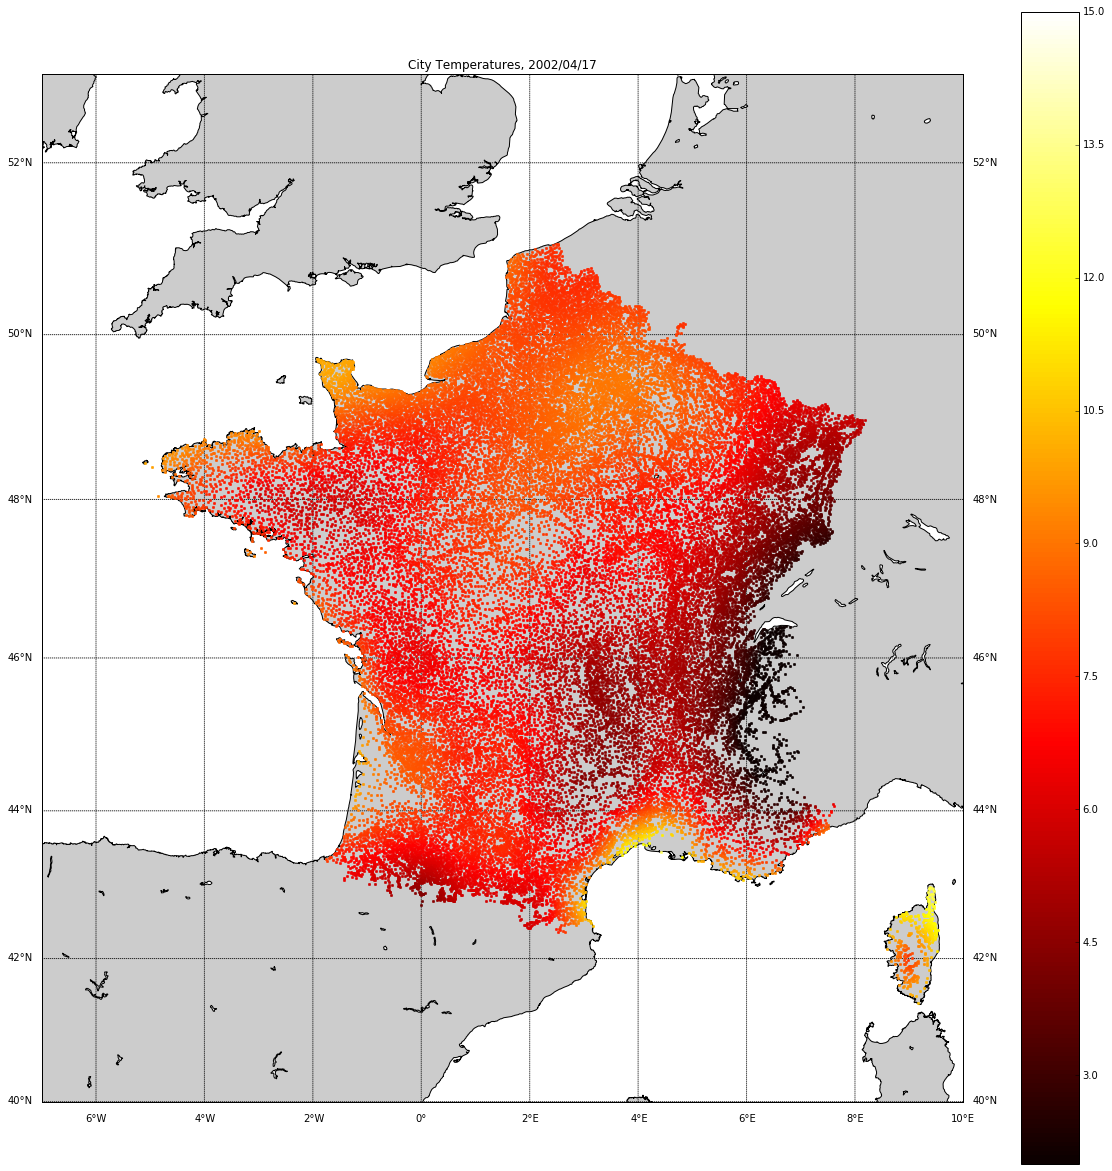

In [54]:
plot_france_locations([(c[5], c[6], c[8]) for c in cities[1:]], title='City Temperatures, 2002/04/17', vmin=2, vmax=15, scale='bs')

In [9]:
# Clean up the city keys. This code is pretty slow, so keep the
# normalized_latlons in memory and don't call the normalization 
# funciton often.

import unicodedata
import editdistance

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def normalize_city_to_latlon(elections, cities):
    city_dic = {}
    for c in cities[1:]:
        city_name = remove_accents(c[3].lower() + c[4].lower())
        city_dic[city_name] = (c[5], c[6])
    misses = 0
    city_names = city_dic.keys()
    city_to_latlon = {}
    for e in elections[1:]:
        try:
            city_name = remove_accents(e[3].lower())
            city_to_latlon[e[3]] = city_dic[city_name]
        except KeyError:
            distances = []
            for city in city_dic:
                distances.append((editdistance.eval(city, city_name), city))
            best_city = min(distances)
            if best_city[0] > 1:
                misses += 1
            else:
                city_to_latlon[e[3]] = city_dic[best_city[1]]
    return city_to_latlon

In [11]:
normalized_latlons = normalize_city_to_latlon(elections, cities)

# Presidentielles 2002

NameError: name 'myrbf' is not defined

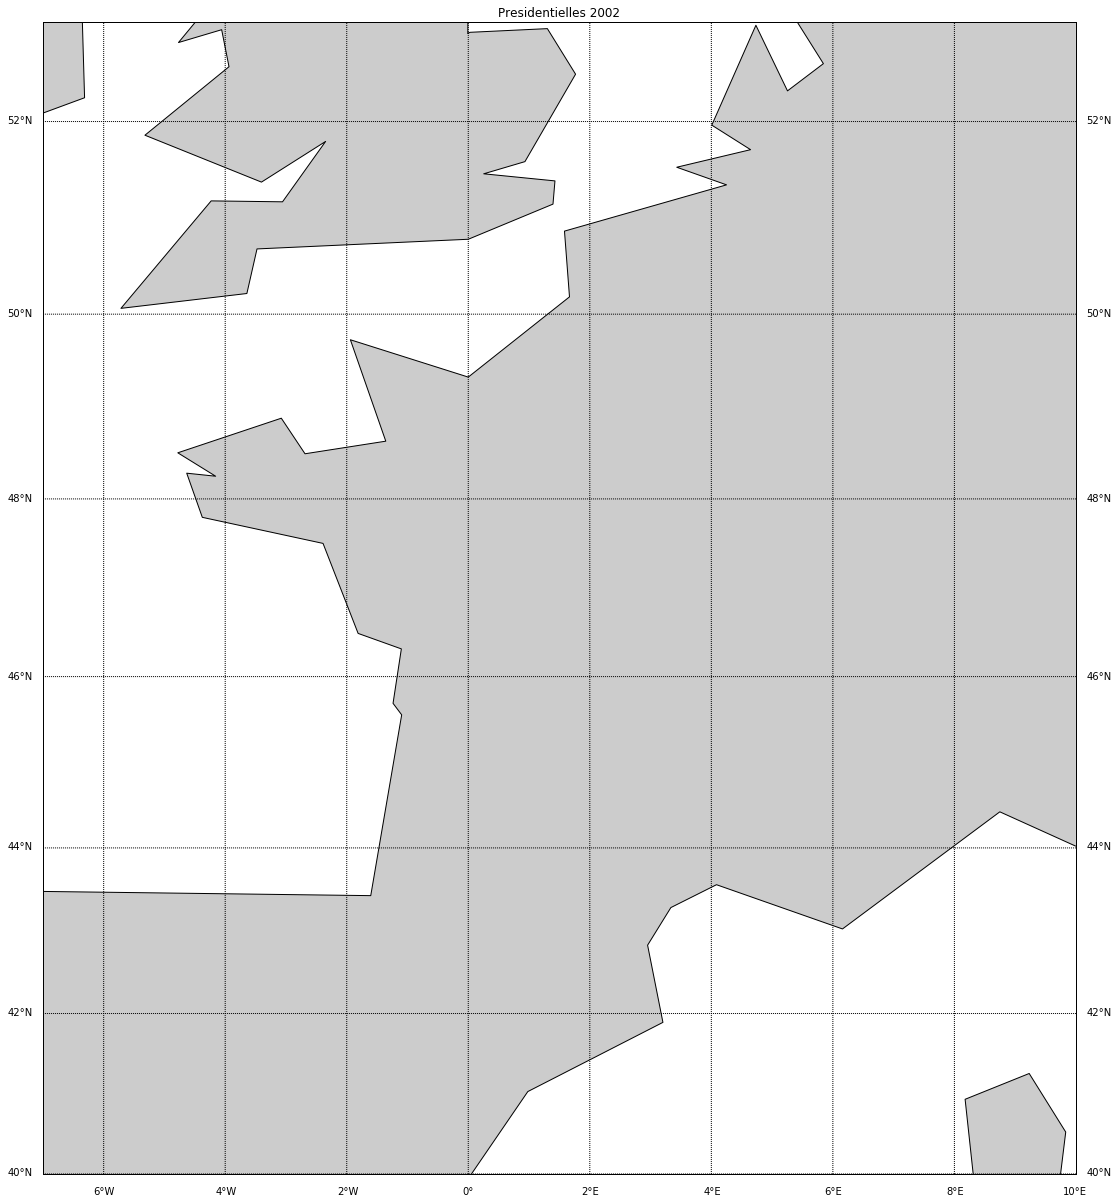

In [12]:
def plot_elections_participation(elections_data, title=''):
    PARTICIPATION_ID = 13
    CITY_ID = 3
    keys = list(normalized_latlons.keys())
    participations = [float(e[PARTICIPATION_ID]) for e in elections_data[1:]]

    latlon_val = []
    for e in elections_data[1:]:
        try:
            latlon_val.append(normalized_latlons[e[CITY_ID]] + (float(e[PARTICIPATION_ID]),))
        except KeyError:
            pass

    sigma = np.std(participations)
    mu = np.mean(participations)
    vmin = mu-2*sigma
    vmax = mu+2*sigma
    plot_france_locations(latlon_val, 10, 30, scale='Normalize', title=title)

elections_2002 = []
with open('presidentielles_data/presidentielles_2002_1ertour.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections_2002.append(r)
        
plot_elections_participation(elections_2002, title='Presidentielles 2002')

# Presidentielles 2007

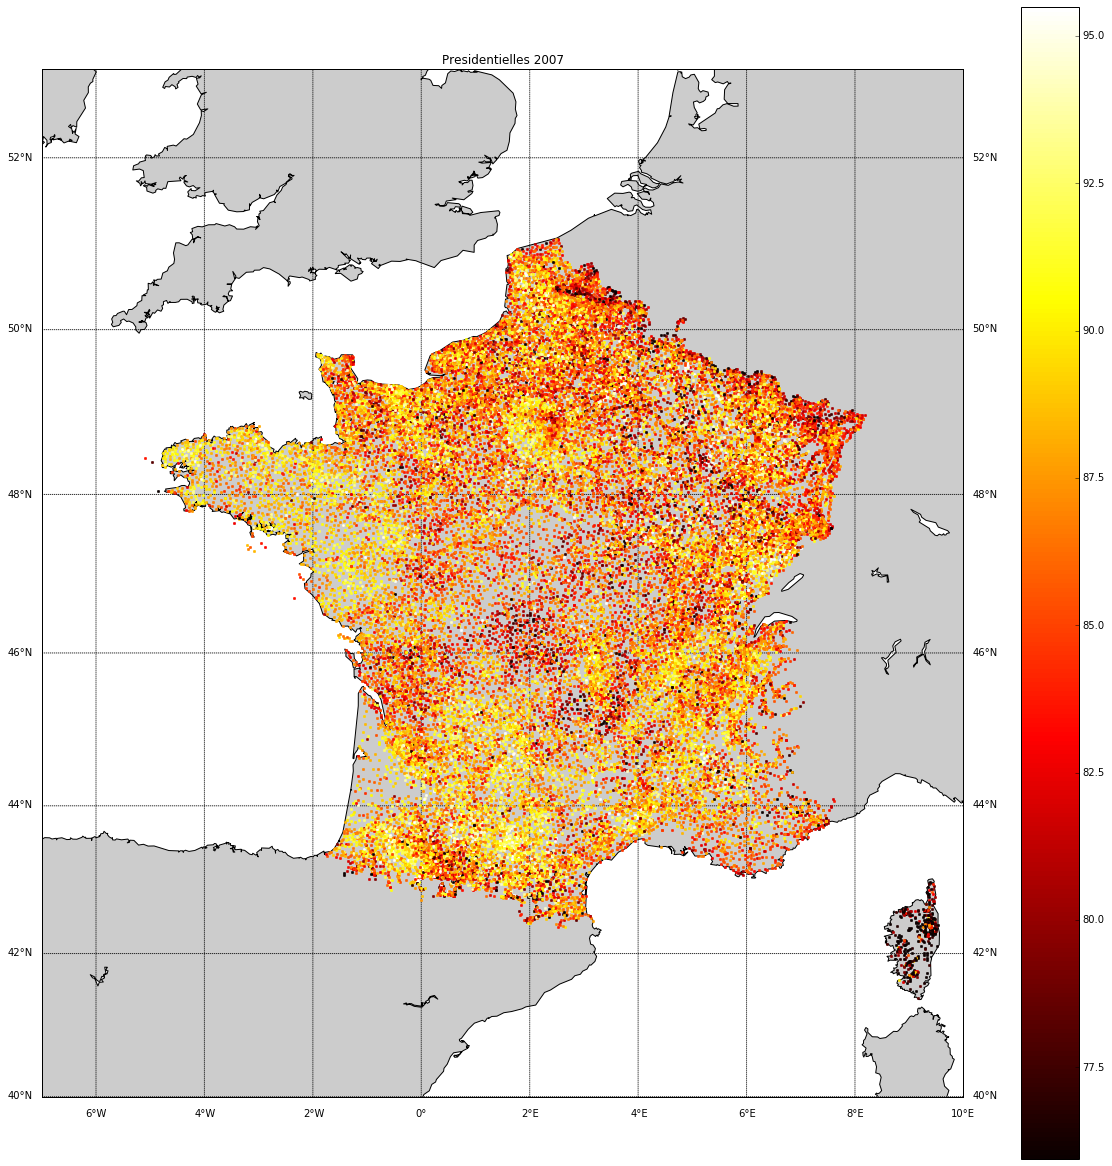

In [21]:
elections_2007 = []
with open('presidentielles_data/presidentielles_2007.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections_2007.append(r)
plot_elections_participation(elections_2007, title='Presidentielles 2007')

# Presidentielles 2012

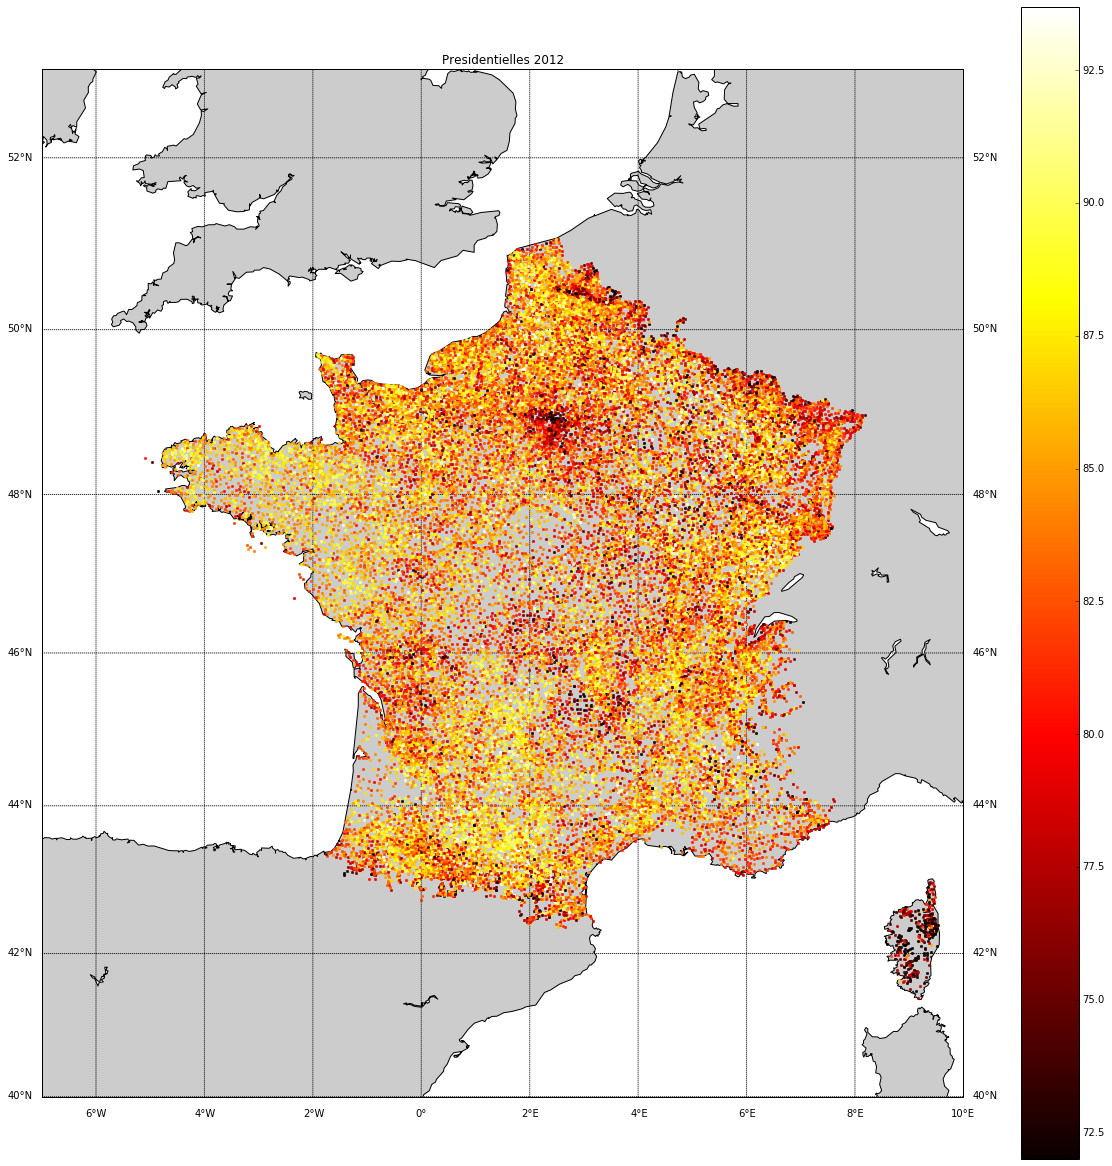

In [22]:
elections_2012 = []
with open('presidentielles_data/presidentielles_2012.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections_2012.append(r)
plot_elections_participation(elections_2012, title='Presidentielles 2012')

In [6]:
%matplotlib inline
import pygrib # import pygrib interface to grib_api
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import addcyclic
import matplotlib.colors as colors
grbs = pygrib.open('res2')    

print(grbs)
for grb in grbs:
    print(grb)
    
data=grb.values - 273.15

lat,lon = grb.latlons() 

1:2 metre temperature:K (instant):regular_ll:surface:level 0:fcst time 12 hrs:from 200204171200


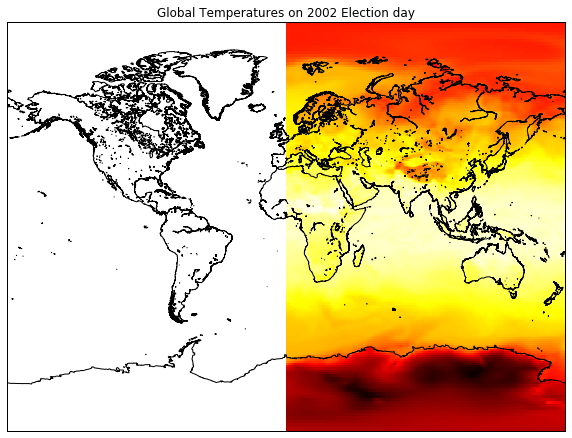

In [7]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# From this point on the code is almost identical to the previous example.
# Plot the field using Basemap. Start with setting the map projection using the limits of the lat/lon data itself:

fig=plt.figure(figsize=(10,10))
m=Basemap(lon_0=180, projection='mill',llcrnrlon=-180, \
  llcrnrlat=-90,urcrnrlat=90,urcrnrlon=180, \
  resolution='i')

# Convert the lat/lon values to x/y projections.
x, y = m(lon,lat)
# Next, plot the field using the fast pcolormesh routine and set the colormap to jet.

cs = m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.hot)
# Add a coastline and axis values.
m.drawcoastlines()

#m.drawmapboundary()
#m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
#m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
# Add a colorbar and title, and then show the plot.

plt.title('Global Temperatures on 2002 Election day')
plt.show()

In [35]:
from scipy.interpolate import Rbf


latmin = 40
latmax = 53
lonmin = -7 
lonmax = 10



newlats = []
newlons = []
newdata = []
for i, la in enumerate(lat.flatten()):
    lo = lon.flatten()[i]
    if lo > 180:
        lo -= 360
    if la > latmin and la < latmax and lo > lonmin and lo < lonmax:
        newlats.append(la)
        newlons.append(lo)
        newdata.append(data.flatten()[i])
        print(data.flatten()[i])
        
print(len(newdata))
myrbf = Rbf(newlats, newlons, newdata, function='linear')


8.46952209473
8.27420959473
8.30936584473
8.86600646973
9.02811584473
8.66678771973
6.12967834473
6.79374084473
4.97147521973
5.35819396973
5.20780334473
4.73319396973
4.15116271973
4.35038146973
6.18045959473
8.00077209473
8.12772521973
7.87186584473
6.30545959473
6.06327209473
6.70389709473
7.44022521973
8.09061584473
8.15311584473
8.35819396973
9.26639709473
9.32108459473
9.11405334473
8.47733459473
6.45780334473
5.91483459473
5.78983459473
5.88553771973
5.40506896973
4.77030334473
4.40506896973
4.17460021973
9.10819396973
9.16288146973
9.03397521973
8.36405334473
6.41874084473
5.92655334473
6.23124084473
6.76639709473
7.43827209473
8.15506896973
8.63358459473
9.21952209473
7.62772521973
7.38358459473
7.35233459473
7.02616271973
6.50467834473
5.90116271973
5.37967834473
5.03006896973
4.80741271973
4.66483459473
4.39725646973
9.68631896973
9.68827209473
9.24686584473
7.20389709473
6.56327209473
6.04374084473
6.41288146973
6.80936584473
7.34842834473
9.78592834473
9.48124084473
8.0378

38.498677665103074


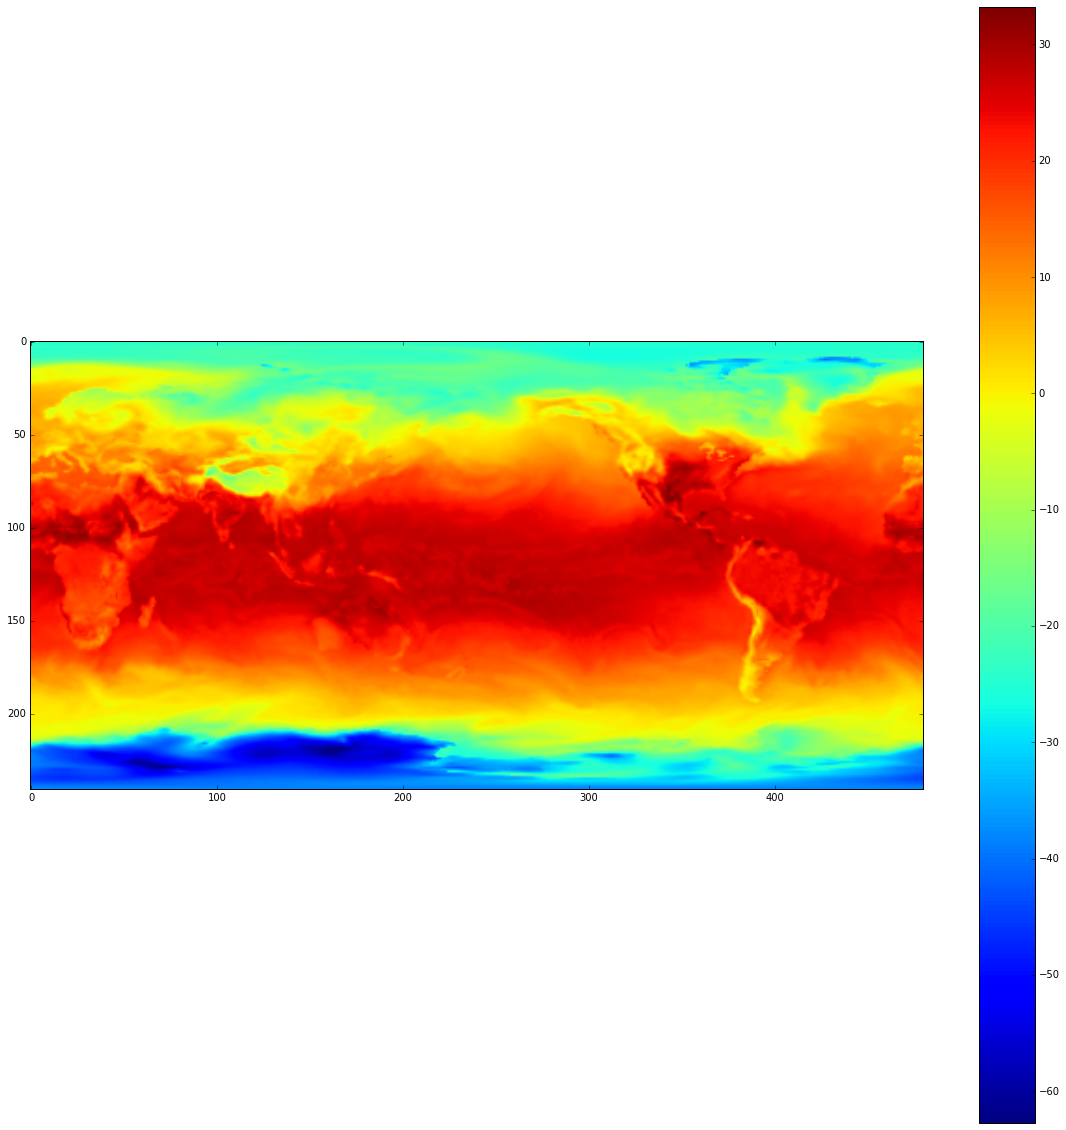

In [44]:
plt.figure(figsize=(20,20))

2.3522219

print(myrbf(2.35,48))
plt.imshow(data)
plt.colorbar()
#print([c[5] for c in cities])